# 目的
gemmaを使う、2fold

https://www.kaggle.com/code/emiz6413/training-gemma-2-9b-4-bit-qlora-fine-tuning

In [6]:
# path setting
EXP_NAME = "check-public-token-num"
MODEL_NAME = "unsloth/gemma-2-9b-it-bnb-4bit"
COMPETITION_NAME = "lmsys"

DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"

# experiment parameter
DEBUG = False
TRAINING = False
UPLOAD_DATA_TO_S3 = False
UPLOAD_DATA_TO_KAGGLE = False
REMOVE_LOCAL_FILE = False
WANDB = False
USE_FOLD = 1
USE_DATA_RATE = 1.0
VALID_DATA_SIZE = 3000

# model parameter
# TRAINING_MAX_LENGTH = 1536
# INFERENCE_MAX_LENGTH = 1536
SEED = 42
EPOCH = 1
LR = 2e-04
TRAIN_BS = 4 # 16
GRAD_ACC_STEP= 128 // TRAIN_BS # 仮想的なバッチサイズはTRAIN_BS * GRAD_ACC_STEPとなる
EVAL_BS = 4 # 16
NUM_LABELS = 3

FREEZE_LAYERS = (
    0  # there're 42 layers in total, we don't add adapters to the first 16 layers
)

# rola parameter
LORA_R = 16
LORA_ALPHA = LORA_R * 2
LORA_DROPOUT = 0.05
LORA_BIAS = "none"

RESUME_FROM_CHECKPOINT= False # 途中から再開する場合はTrueにする
# TRAINED_MODEL_PATH = "lmsys/trained_models/e006-use-concat"

In [7]:
!nvidia-smi

Mon Jul 22 23:35:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0            323W /  400W |   22891MiB /  40960MiB |    100%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [8]:
!python --version

Python 3.10.14


In [9]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return "kernel", f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return "nohup", f"../../{base_path}"
    elif cwd == f"/content":
        print("Google Colab!")
        return "colab", f"/content/drive/MyDrive/Kaggle/{COMPETITION_NAME}/{base_path}"
    elif cwd.startswith("/home/shinichiro.saito"):
        print("GCP!")
        return "GCP", f"/home/shinichiro.saito/{COMPETITION_NAME}/{base_path}"
    else:
        raise Exception("Unknown environment")


ENV_NAME, DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
_, MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/home/shinichiro.saito/lmsys/lmsys/eda
GCP!
/home/shinichiro.saito/lmsys/data
/home/shinichiro.saito/lmsys/lmsys/eda
GCP!
/home/shinichiro.saito/lmsys/trained_models/check-public-token-num


In [10]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [11]:
if ENV_NAME != "GCP":
    %pip install -qq polars==1.0.0
    %pip install -qq transformers==4.42.3
    %pip install -qq datasets==2.20.0
    %pip install -qq evaluate==0.4.2
    %pip install -qq seqeval==1.2.2
    %pip install -qq accelerate==0.32.0
    %pip install -qq python-dotenv==1.0.1
    %pip install -qq wandb==0.17.4
    %pip install -qq bitsandbytes==0.43.1
    %pip install -qq accelerate==0.32.0
    %pip install -qq peft==0.11.1

    # formatter
    %pip install -qq black isort

    %pip install -qq kaggle

# import

In [12]:
import os
import random
import ast
import json

import polars as pl
import numpy as np
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, LayerNorm, MSELoss
import wandb
from datasets import (
    Dataset,
    DatasetDict,
    Value,
    concatenate_datasets,
    load_dataset,
    ClassLabel,
)
from tokenizers import AddedToken
from tqdm.auto import tqdm
from scipy.special import softmax
from sklearn.metrics import log_loss
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    GemmaTokenizerFast,
    Gemma2Config,
    PreTrainedTokenizerBase,
    EvalPrediction,
    Trainer,
    DataCollatorWithPadding,
    TrainingArguments,
)

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

from sklearn.metrics import log_loss, accuracy_score

In [13]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()

In [14]:
import transformers
import datasets
import evaluate
import bitsandbytes
import accelerate
import peft

assert transformers.__version__ == "4.42.3"
assert datasets.__version__ == "2.20.0"
assert evaluate.__version__ == "0.4.2"
assert bitsandbytes.__version__ == "0.43.1"
assert accelerate.__version__ == "0.32.0"
assert peft.__version__ == "0.11.1"

In [15]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [16]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

# Wandb

In [17]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project=COMPETITION_NAME, name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

'none'

# Data Import & Preprocess

In [20]:
with open(f"{DATA_PATH}/label_stratified_fold.json") as f:
    label_stratified_fold = json.load(f)

In [21]:
train = (
    pl.read_csv(f"{DATA_PATH}/train.csv")
    # .with_columns(
    #     pl.col("prompt").str.json_decode(),
    #     pl.col("response_a").str.json_decode(),
    #     pl.col("response_b").str.json_decode(),
    # )
    # .with_columns(  # 長さの情報を追加する
    #     pl.col("prompt")
    #     .map_elements(lambda x: len(x), return_dtype=pl.Int64)
    #     .alias("len_prompt"),
    #     pl.col("response_a")
    #     .map_elements(lambda x: len(x), return_dtype=pl.Int64)
    #     .alias("len_response_a"),
    #     pl.col("response_b")
    #     .map_elements(lambda x: len(x), return_dtype=pl.Int64)
    #     .alias("len_response_b"),
    # )
    # .with_columns(  # 最後のレスポンスのみを取得する
    #     pl.col("prompt")
    #     .map_elements(lambda x: x[-1], return_dtype=pl.String)
    #     .alias("last_prompt"),
    #     pl.col("response_a")
    #     .map_elements(lambda x: x[-1], return_dtype=pl.String)
    #     .alias("last_response_a"),
    #     pl.col("response_b")
    #     .map_elements(lambda x: x[-1], return_dtype=pl.String)
    #     .alias("last_response_b"),
    # )
    # .with_columns(  # 最後のレスポンスがNoneの場合を空文字にする、約60件程度
    #     pl.col("last_response_a").fill_null(""),
    #     pl.col("last_response_b").fill_null(""),
    # )
    # .with_columns(  # labelを付与する
    #     pl.when(pl.col("winner_model_a") == 1)
    #     .then(0)
    #     .when(pl.col("winner_model_b") == 1)
    #     .then(1)
    #     .when(pl.col("winner_tie") == 1)
    #     .then(2)
    #     .alias("label"),
    # )
    # .select(  # 元のprompt, responseを削除する
    #     pl.exclude(["prompt", "response_a", "response_b"])
    # )
    .with_columns(  # foldを追加する
        pl.col("id").replace(label_stratified_fold).alias("fold")
    )
)

In [22]:
if DEBUG:
    train = train.head(100)

In [23]:
train_dataset = Dataset.from_polars(train)

In [24]:
train_dataset

Dataset({
    features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie', 'fold'],
    num_rows: 57477
})

In [25]:
# 計算を早くするために、データを減らす
if not DEBUG:
    train_dataset = train_dataset.select(
        range(
            int(len(train_dataset) * USE_DATA_RATE)
        )
    )

# Model

In [26]:
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA, # low-rankマトリクスのスケーリングファクター
    # only target self-attention
    # target_modules=["q_proj", "k_proj", "v_proj"],
    target_modules=[ # Linear層を全て含める
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj"
    ],
    layers_to_transform=[i for i in range(42) if i >= FREEZE_LAYERS],
    lora_dropout=LORA_DROPOUT, # LoRAレイヤーのドロップアウト確率
    bias=LORA_BIAS,
    task_type=TaskType.SEQ_CLS,
)

In [27]:
# tokenizer = GemmaTokenizerFast.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_eos_token = True  # We'll add <eos> at the end
tokenizer.padding_side = "right"
# tokenizer.add_special_tokens({"additional_special_tokens": ["[SEP]"]})

In [28]:
# model = AutoModelForSequenceClassification.from_pretrained(
#     MODEL_NAME,
#     num_labels=NUM_LABELS,
#     torch_dtype=torch.float16,
#     device_map="auto",
# )
# model.config.use_cache = False
# model = prepare_model_for_kbit_training(model)
# model = get_peft_model(model, lora_config)
# # model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)
# print(model)
# print(model.print_trainable_parameters())

In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

# Tokenize

In [32]:
class CustomTokenizer:
    def __init__(
        self,
        tokenizer: PreTrainedTokenizerBase,
        # max_length: int
    ) -> None:
        self.tokenizer = tokenizer
        # self.max_length = max_length

    def __call__(self, batch: dict) -> dict:
        prompt = ["<prompt>: " + self.process_text(t) for t in batch["prompt"]]
        response_a = ["\n\n<response_a>: " + self.process_text(t) for t in batch["response_a"]]
        response_b = ["\n\n<response_b>: " + self.process_text(t) for t in batch["response_b"]]
        texts = [p + r_a + r_b for p, r_a, r_b in zip(prompt, response_a, response_b)]
        # tokenized = self.tokenizer(texts, max_length=self.max_length, truncation=True)
        tokenized = self.tokenizer(texts, truncation=False)
        labels=[]
        for a_win, b_win in zip(batch["winner_model_a"], batch["winner_model_b"]):
            if a_win:
                label = 0
            elif b_win:
                label = 1
            else:
                label = 2
            labels.append(label)
        return {**tokenized, "labels": labels}

    @staticmethod
    def process_text(text: str) -> str:
        return " ".join(eval(text, {"null": ""}))

In [33]:
train_dataset = train_dataset.map(
    # CustomTokenizer(tokenizer, max_length=TRAINING_MAX_LENGTH),
    CustomTokenizer(tokenizer),
    batched=True
)

Map:   0%|          | 0/57477 [00:00<?, ? examples/s]

In [34]:
print(train_dataset)

Dataset({
    features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie', 'fold', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 57477
})


In [37]:
text_lens = []
for input_ids in train_dataset["input_ids"]:
    text_lens.append(len(input_ids))

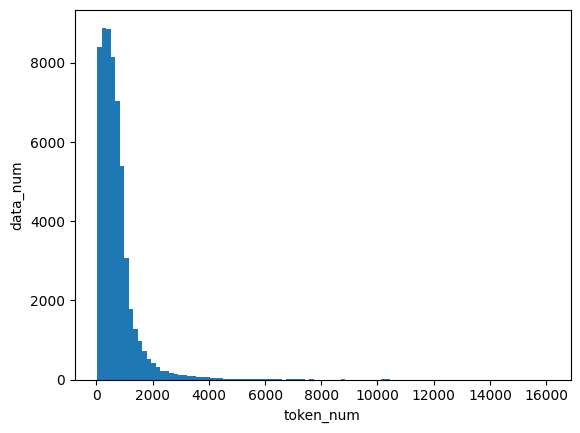

In [47]:
import matplotlib.pyplot as plt
plt.hist(text_lens, bins=100);
plt.xlabel("token_num");
plt.ylabel("data_num");

In [48]:
pl.DataFrame(text_lens).describe()

statistic,column_0
str,f64
"""count""",57477.0
"""null_count""",0.0
"""mean""",698.336239
"""std""",692.978435
"""min""",22.0
"""25%""",288.0
"""50%""",554.0
"""75%""",871.0
"""max""",16067.0


In [64]:
def text_rate(max_len: int, text_lens: list) -> float:
    rate = sum(num <= max_len for num in text_lens) / len(text_lens)
    print(f"max_len:{max_len}: truncateされない割合: {rate:.4f}")
    return 

text_rate(512, text_lens)
text_rate(1024, text_lens)
text_rate(1536, text_lens)
text_rate(2048, text_lens)
text_rate(2560, text_lens)
text_rate(3072, text_lens)
text_rate(3584, text_lens)
text_rate(4096, text_lens)

max_len:512: truncateされない割合: 0.4627
max_len:1024: truncateされない割合: 0.8296
max_len:1536: truncateされない割合: 0.9274
max_len:2048: truncateされない割合: 0.9626
max_len:2560: truncateされない割合: 0.9773
max_len:3072: truncateされない割合: 0.9856
max_len:3584: truncateされない割合: 0.9908
max_len:4096: truncateされない割合: 0.9940


In [63]:
512 * 8

4096

In [26]:
# def tokenize(examples, max_token_length: int):
#     separator = " [SEP] "

#     joined_text = (
#         examples["last_prompt"]
#         + separator
#         + examples["last_response_a"]
#         + separator
#         + examples["last_response_b"]
#     )

#     return tokenizer(
#         joined_text,
#         max_length=max_token_length,
#         truncation=True,
#         padding="max_length",
#     )


# train_dataset = train_dataset.map(
#     tokenize,
#     batched=False,
#     fn_kwargs={"max_token_length": TRAINING_MAX_LENGTH},
#     num_proc=NUM_PROC,
# )

# Train Test Split

In [27]:
filtered_train = train_dataset.filter(lambda x: x["fold"] != USE_FOLD, num_proc=NUM_PROC)
filtered_valid = train_dataset.filter(lambda x: x["fold"] == USE_FOLD, num_proc=NUM_PROC)
filtered_valid = filtered_valid.select(range(min(VALID_DATA_SIZE, len(filtered_valid))))

train_valid_dataset = DatasetDict(
    {
        "train": filtered_train,
        "valid": filtered_valid,
    }
)

del filtered_train, filtered_valid

Filter (num_proc=12):   0%|          | 0/5747 [00:00<?, ? examples/s]

Filter (num_proc=12):   0%|          | 0/5747 [00:00<?, ? examples/s]

In [28]:
print(train_valid_dataset)

In [29]:
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     preds_prob = softmax(predictions, axis=-1)
#     return {"log_loss": log_loss(labels, preds_prob)}


def compute_metrics(eval_pred) -> dict:
    preds, labels = eval_pred
    preds_prob = softmax(preds, axis=-1)
    return {
        "log_loss": log_loss(y_true=labels, y_pred=preds_prob),
        "acc": accuracy_score(y_true=labels, y_pred=preds.argmax(-1)),
    }

In [30]:
# スケジューラの設定
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    overwrite_output_dir=True,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_STEP,
    eval_accumulation_steps=GRAD_ACC_STEP,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=0.1,
    save_strategy="steps",
    save_steps=0.1,
    save_total_limit=10,
    logging_steps=2,
    seed=SEED,
    metric_for_best_model="eval_loss",
    warmup_ratio=0.1,
    lr_scheduler_type="cosine_with_restarts", # "linear", # "constant_with_warmup",
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
    optim="adamw_8bit",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_valid_dataset["train"],
    # train_dataset=ConcatDataset(train_valid_dataset["train"]),
    eval_dataset=train_valid_dataset["valid"],
    # eval_dataset=ConcatDataset(train_valid_dataset["valid"]),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [31]:
if TRAINING:
    # モデルの学習
    trainer.train(
        resume_from_checkpoint = RESUME_FROM_CHECKPOINT if RESUME_FROM_CHECKPOINT else None
    )
    # ログの保存に利用したストレージを削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)
else:
    # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
    model = AutoModelForSequenceClassification.from_pretrained(
        TRAINED_MODEL_PATH,
        num_labels=NUM_LABELS,
    )
    # model = CustomDebertaSequenceClassification.from_pretrained(MODEL_NAME)

    args = TrainingArguments(
        ".",
        per_device_eval_batch_size=4,
        report_to="none",
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=args,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

Step,Training Loss,Validation Loss,Log Loss,Acc,Runtime,Samples Per Second,Steps Per Second
3,1.888100,1.807651,1.807635,0.351366,336.339300,5.551000,1.388000
6,1.477000,1.346623,1.346632,0.369041,336.186000,5.553000,1.389000
9,1.324400,1.222064,1.222063,0.385110,336.150500,5.554000,1.389000
12,1.356500,1.284015,1.284018,0.384574,336.019100,5.556000,1.390000
15,1.318500,1.157006,1.157014,0.404928,336.113800,5.555000,1.389000
18,1.192800,1.181270,1.181275,0.378147,336.230300,5.553000,1.389000
21,1.112800,1.163323,1.163327,0.426888,336.091800,5.555000,1.390000
24,1.141300,1.140709,1.140707,0.427959,336.114800,5.555000,1.389000
27,1.164700,1.163367,1.163368,0.373862,336.107200,5.555000,1.389000
30,1.160400,1.149181,1.149173,0.389930,336.060100,5.556000,1.390000


```
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
TODO: この　Warningが問題ないのかを調べる

```

# valid_datasetの作成・保存

In [32]:
# TRAININGをINFERRENCEでMAX_TOKENを変えるために、validを作り直す
valid_dataset = train_dataset.filter(
    lambda example: example["id"] in train_valid_dataset["valid"]["id"],
    num_proc=NUM_PROC,
)

valid_dataset = valid_dataset.map(
    CustomTokenizer(tokenizer, max_length=INFERENCE_MAX_LENGTH),
    batched=True,
    num_proc=NUM_PROC,
)

# valid_dataset = valid_dataset.map(
#     tokenize,
#     batched=False,
#     fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
#     num_proc=NUM_PROC,
# )

# valid_dataset = valid_dataset.map(
#     tokenize,
#     batched=False,
#     fn_kwargs={
#         "suffix": "a",
#         "max_token_length": INFERENCE_MAX_LENGTH
#     },
#     num_proc=NUM_PROC,
# ).map(
#     tokenize,
#     batched=False,
#     fn_kwargs={
#         "suffix": "b",
#         "max_token_length": INFERENCE_MAX_LENGTH
#     },
#     num_proc=NUM_PROC,
# )


def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_dataset = train_valid_dataset["valid"]

valid_pred = softmax(trainer.predict(valid_dataset).predictions, axis=-1)
# valid_pred = softmax(trainer.predict(ConcatDataset(valid_dataset)).predictions, axis=-1)

np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
)

valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset")

Filter (num_proc=12):   0%|          | 0/5747 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/1867 [00:00<?, ? examples/s]

Map:   0%|          | 0/1867 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1867 [00:00<?, ? examples/s]

# CVの計算

In [33]:
cv_score = log_loss(valid_dataset["labels"], valid_pred)
print(f"CV Score: {cv_score}")

In [34]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# AWSへのアップロード

In [35]:
# S3へのアップロード
# TODO: colabでは動かないため直す
if not DEBUG and UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://{COMPETITION_NAME}/trained_model/{output_name}"
    )

In [36]:
# ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e005-regression /notebooks/automated_essay_scoring/trained_models/e005-regression

# Kaggle Datasetへのupload

In [37]:
import os

os.system("mkdir -p ~/.kaggle/")
os.system(f"cp /{DATA_PATH}/kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

0

In [38]:
if not DEBUG and UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

# ローカルからのデータの削除

In [39]:
# if not DEBUG and REMOVE_LOCAL_FILE:
#     # ローカルからは削除
#     os.system(f"rm -rf {MODEL_OUTPUT_PATH}")

In [40]:
if WANDB:
    wandb.finish()

In [41]:
print("finish Notebook!")